In [1]:
!pip install gymnasium[classic_control] matplotlib seaborn pandas


In [2]:
import numpy as np
import gymnasium as gym
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import time
import os


In [3]:
def epsilon_greedy(Q, state, nA, epsilon):
    if random.random() < epsilon:
        return random.choice(np.arange(nA))
    return np.argmax(Q[state])

In [4]:
def mc_control_first_visit(env, episodes=5000, gamma=0.99):
    returns_sum, returns_count = defaultdict(float), defaultdict(float)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards, success = [], []
    start = time.time()

    for i in range(episodes):
        epsilon = max(0.05, 1.0 - i / episodes)
        state, _ = env.reset()
        episode, done = [], False

        while not done:
            action = epsilon_greedy(Q, state, env.action_space.n, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode.append((state, action, reward))
            state = next_state

        G, visited = 0, set()
        for t in reversed(range(len(episode))):
            s, a, r = episode[t]
            G = gamma * G + r
            if (s, a) not in visited:
                visited.add((s, a))
                returns_sum[(s, a)] += G
                returns_count[(s, a)] += 1
                Q[s][a] = returns_sum[(s, a)] / returns_count[(s, a)]

        rewards.append(sum(x[2] for x in episode))
        success.append(1 if episode[-1][2] == 1.0 else 0)

    return Q, rewards, success, time.time() - start

In [5]:
def mc_control_every_visit(env, episodes=5000, gamma=0.99):
    returns_sum, returns_count = defaultdict(float), defaultdict(float)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards, success = [], []
    start = time.time()

    for i in range(episodes):
        epsilon = max(0.05, 1.0 - i / episodes)
        state, _ = env.reset()
        episode, done = [], False

        while not done:
            action = epsilon_greedy(Q, state, env.action_space.n, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode.append((state, action, reward))
            state = next_state

        G = 0
        for t in reversed(range(len(episode))):
            s, a, r = episode[t]
            G = gamma * G + r
            returns_sum[(s, a)] += G
            returns_count[(s, a)] += 1
            Q[s][a] = returns_sum[(s, a)] / returns_count[(s, a)]

        rewards.append(sum(x[2] for x in episode))
        success.append(1 if episode[-1][2] == 1.0 else 0)

    return Q, rewards, success, time.time() - start

In [6]:
# Run agents
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=True)
Qf, rf, sf, tf = mc_control_first_visit(env)
Qe, re, se, te = mc_control_every_visit(env)

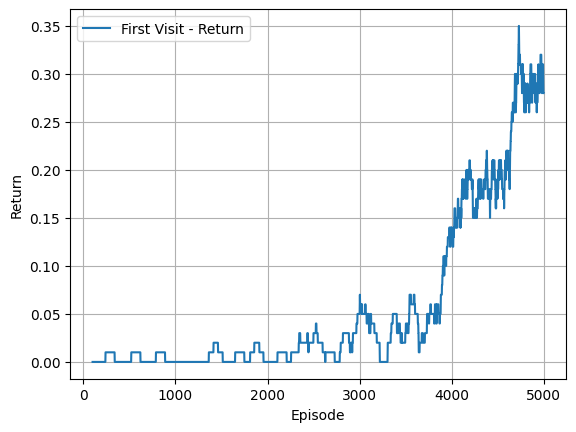

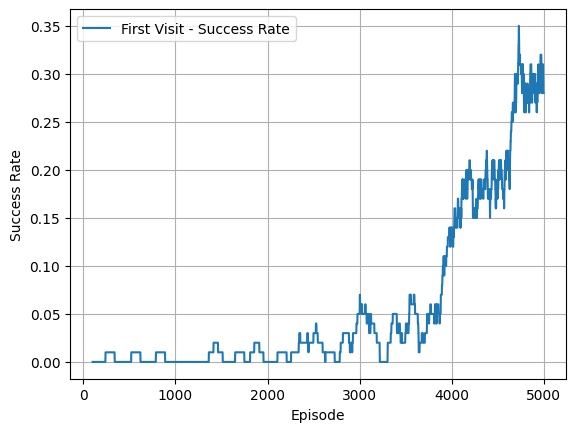

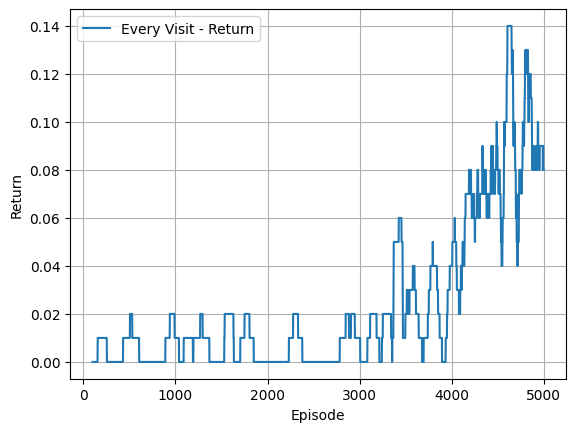

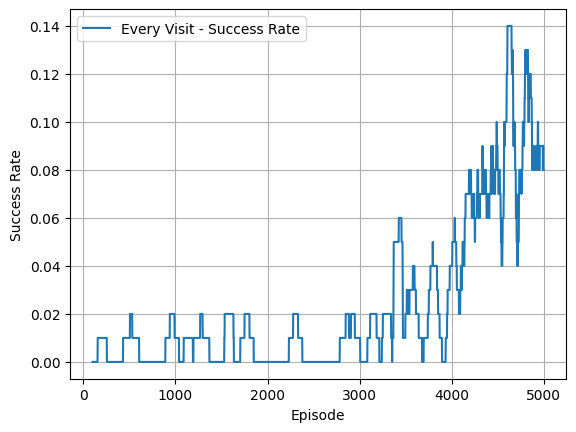

In [7]:
# Plots
def plot_metric(values, label, ylabel):
    rolling = pd.Series(values).rolling(100).mean()
    plt.plot(rolling, label=label)
    plt.xlabel("Episode")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.show()

plot_metric(rf, "First Visit - Return", "Return")
plot_metric(sf, "First Visit - Success Rate", "Success Rate")
plot_metric(re, "Every Visit - Return", "Return")
plot_metric(se, "Every Visit - Success Rate", "Success Rate")

In [8]:
# Summary
summary = pd.DataFrame({
    "Agent": ["First Visit MC", "Every Visit MC"],
    "Variance": [np.var(rf), np.var(re)],
    "Mean Return (Last 100)": [np.mean(rf[-100:]), np.mean(re[-100:])],
    "Mean Success Rate (Last 100)": [np.mean(sf[-100:]), np.mean(se[-100:])],
    "Episodes to 0.6+ Return": [
        next((i for i, val in enumerate(pd.Series(rf).rolling(100).mean()) if val > 0.6), -1),
        next((i for i, val in enumerate(pd.Series(re).rolling(100).mean()) if val > 0.6), -1)
    ],
    "Training Time (s)": [tf, te]
})
print(summary)

            Agent  Variance  Mean Return (Last 100)  \
0  First Visit MC  0.056048                    0.28   
1  Every Visit MC  0.023234                    0.08   

   Mean Success Rate (Last 100)  Episodes to 0.6+ Return  Training Time (s)  
0                          0.28                       -1          11.025939  
1                          0.08                       -1           2.943815  
